# Lab 3 — Dimensionality reduction

## 3.1 - Preaparation

In [1]:
import json
import matplotlib.pyplot as plt
import numpy as np

from operator import itemgetter

%matplotlib inline
plt.style.use("ggplot")

In [2]:
!hdfs dfs -cat /ix/ml-20m/genome-tags.txt | tail -n 2
!hdfs dfs -cat /ix/ml-20m/genome-scores.txt | tail -n 2
!hdfs dfs -cat /ix/ml-20m/movies.txt | tail -n 2

{"tagId": 1127, "tag": "zombie"}
{"tagId": 1128, "tag": "zombies"}
{"relevance": 0.11449999999999999, "tagId": 1127, "movieId": 131170}
{"relevance": 0.02174999999999999, "tagId": 1128, "movieId": 131170}
{"genres": ["(no genres listed)"], "movieId": 131260, "title": "Rentun Ruusu (2001)"}
{"genres": ["Adventure", "Fantasy", "Horror"], "movieId": 131262, "title": "Innocence (2014)"}


In [3]:
scores = sc.textFile("/ix/ml-20m/genome-scores.txt").map(json.loads)
data = sc.textFile("/ix/ml-20m/genome-tags.txt").map(json.loads) #.map(j => (j['tagId'], j['movieId'], j))
movies = sc.textFile("/ix/ml-20m/movies.txt").map(json.loads)
tag2name = dict(data.map(itemgetter("tagId", "tag")).collect())

In [4]:
buildTuple = lambda j: (j['tagId'], (j['movieId'], j['relevance']))
mapped = scores.map(buildTuple).groupByKey().mapValues(dict).sortByKey().persist()

In [5]:
mapped.take(2)

[(1,
  {1: 0.025000000000000022,
   2: 0.03975000000000001,
   3: 0.04349999999999998,
   4: 0.037250000000000005,
   5: 0.04199999999999998,
   6: 0.028249999999999997,
   7: 0.04575000000000001,
   8: 0.03075,
   9: 0.034999999999999976,
   10: 0.9997499999999999,
   11: 0.04275000000000001,
   12: 0.04025000000000001,
   13: 0.03199999999999997,
   14: 0.025749999999999995,
   15: 0.04625000000000001,
   16: 0.028249999999999997,
   17: 0.022249999999999992,
   18: 0.035499999999999976,
   19: 0.04525000000000001,
   20: 0.04899999999999999,
   21: 0.03125,
   22: 0.026000000000000023,
   23: 0.07400000000000001,
   24: 0.033499999999999974,
   25: 0.027000000000000024,
   26: 0.02124999999999999,
   27: 0.027249999999999996,
   28: 0.022249999999999992,
   29: 0.02350000000000002,
   30: 0.027749999999999997,
   31: 0.04099999999999998,
   32: 0.022749999999999992,
   33: 0.03875000000000001,
   34: 0.02350000000000002,
   35: 0.04025000000000001,
   36: 0.026000000000000023,
   37

In [17]:
seqOp = lambda accTup, entry: (   min(accTup[0], len(entry[1]))     , max(accTup[0], len(entry[1]))   )
combOp = lambda tup1, tup2: (min(tup1[0], tup2[0]), max(tup1[1], tup2[1]))
minV, maxV = mapped.aggregate((movies.count(), 0), seqOp, combOp)
minV == maxV

True

We checked that all the tags are associated to the same number of movies. As the minimum number of movies per tag is equal to the maximum, each movie has a relevance for every tag: the data is not sparse (we did not consider movies without tags)

In [11]:
N = mapped.count()
sc.parallelize(list(range(1, N + 1))).subtract(mapped.keys()).count()

0

We checked that the tag ids are sequential integers from $1$ to $max(tagId)$. Therefore we know how to retrieve a tag from the matrix: $tagId = rowNumber + 1$.

Let's build the matrix:

In [12]:
rows = mapped.map(lambda kv: list(kv[1].values()))
M = np.matrix(rows.collect())

Remark that we collect a list of lists. We could use PySparks `mllib.linalg` to build Vectors and Matrices. However this module uses numpy arrays and matrices on a single machine, therefore this makes no difference.

We compute the matrix $M$

In [13]:
M.shape

(1128, 10381)

In [15]:
# Plot the variance of each dimension / tag ????

The covariance matrix of $M$ is $C = \frac{M^TM}{n}$ where $n$ is the number of rows of the matrix (from the class slides):
$$C = \frac{M^T M}{n}$$

In [53]:
C = (M.T @ M) / M.shape[0]

We compute the eigendecomposition of $C$ and plot its eigenvalues:

In [54]:
eigenvalues, eigenvectors = np.linalg.eigh(C)

10381


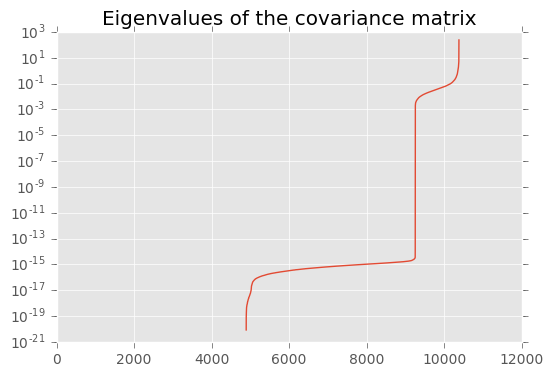

In [66]:
print(len(eigenvalues))
plt.semilogy(eigenvalues) # semilogy or normal plot?
plt.title('Eigenvalues of the covariance matrix')

In [16]:
# EXPLAIN

## 3.2 - Concept Space

matrix([[ 0.06504812,  0.03357072,  0.02619206, ...,  0.0243053 ,
          0.03891234,  0.03994502],
        [ 0.03357072,  0.03554497,  0.01860298, ...,  0.01674476,
          0.02977519,  0.02927285],
        [ 0.02619206,  0.01860298,  0.02119372, ...,  0.01667485,
          0.02210848,  0.02303542],
        ..., 
        [ 0.0243053 ,  0.01674476,  0.01667485, ...,  0.02804842,
          0.02165058,  0.0226465 ],
        [ 0.03891234,  0.02977519,  0.02210848, ...,  0.02165058,
          0.04823734,  0.03683953],
        [ 0.03994502,  0.02927285,  0.02303542, ...,  0.0226465 ,
          0.03683953,  0.05705012]])